In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
# Define Transformer model for classification
class CustomTransformer(nn.Module):
    def __init__(self, input_size, num_classes, d_model=64, nhead=8, num_encoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(CustomTransformer, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)  # Project input to model dimension
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))  # Positional Encoding
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True,  # Ensure batch is first dim
            ),
            num_layers=num_encoder_layers,
        )
        self.fc = nn.Linear(d_model, num_classes)  # Final classification layer

    def forward(self, x):
        # Project input to d_model dimension
        x = self.input_projection(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]
        
        # Pass through Transformer Encoder
        x = self.encoder(x)
        
        # Take the last token's representation for classification
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [3]:
video_directory = 'TRAIN_5'

sum = 0

gesture_folder = np.array(os.listdir(video_directory))
for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    sum += len(gesture) 
    # print(gestures, end =" : ")        
    # print(len(gesture))

print("Total gestures: ", len(gesture_folder), "; Total videos: ", sum)

label_map = {label: num for num, label in enumerate(gesture_folder)}

X = np.load('train_numpy/train_5/X_TRAIN_5.npy')
y = np.load('train_numpy/train_5/y_TRAIN_5.npy')

y = tf.keras.utils.to_categorical(y, num_classes=len(gesture_folder))
y_labels = np.argmax(y, axis=1)

X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=0.2, stratify=y_labels, random_state=42)

Total gestures:  107 ; Total videos:  7098


In [4]:
# Convert data to tensors
X_train = torch.tensor(X_train_ori, dtype=torch.float32)
X_test = torch.tensor(X_test_ori, dtype=torch.float32)
y_train = torch.tensor(y_train_ori.argmax(axis=1), dtype=torch.long)
y_test = torch.tensor(y_test_ori.argmax(axis=1), dtype=torch.long)

# DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [6]:
# Model, loss, and optimizer
input_size = X_train.size(-1)
num_classes = len(label_map)
model = CustomTransformer(input_size=input_size, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
loss_history = []

# loss threshold
loss_threshold = 0.1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    if avg_loss < loss_threshold:
        print(f'Loss threshold of {loss_threshold} reached. Stopping training.')
        break

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')


Epoch [1/200], Loss: 3.9136
Epoch [2/200], Loss: 2.5265
Epoch [3/200], Loss: 1.5953
Epoch [4/200], Loss: 1.0929
Epoch [5/200], Loss: 0.8054
Epoch [6/200], Loss: 0.6117
Epoch [7/200], Loss: 0.4811
Epoch [8/200], Loss: 0.4245
Epoch [9/200], Loss: 0.3434
Epoch [10/200], Loss: 0.3162
Epoch [11/200], Loss: 0.2698
Epoch [12/200], Loss: 0.2199
Epoch [13/200], Loss: 0.2014
Epoch [14/200], Loss: 0.2150
Epoch [15/200], Loss: 0.1774
Epoch [16/200], Loss: 0.1552
Epoch [17/200], Loss: 0.1576
Epoch [18/200], Loss: 0.1494
Epoch [19/200], Loss: 0.1137
Epoch [20/200], Loss: 0.1298
Epoch [21/200], Loss: 0.1513
Epoch [22/200], Loss: 0.1159
Epoch [23/200], Loss: 0.1008
Epoch [24/200], Loss: 0.1226
Epoch [25/200], Loss: 0.1197
Epoch [26/200], Loss: 0.0956
Loss threshold of 0.1 reached. Stopping training.
Test Loss: 0.2175, Test Accuracy: 0.9331


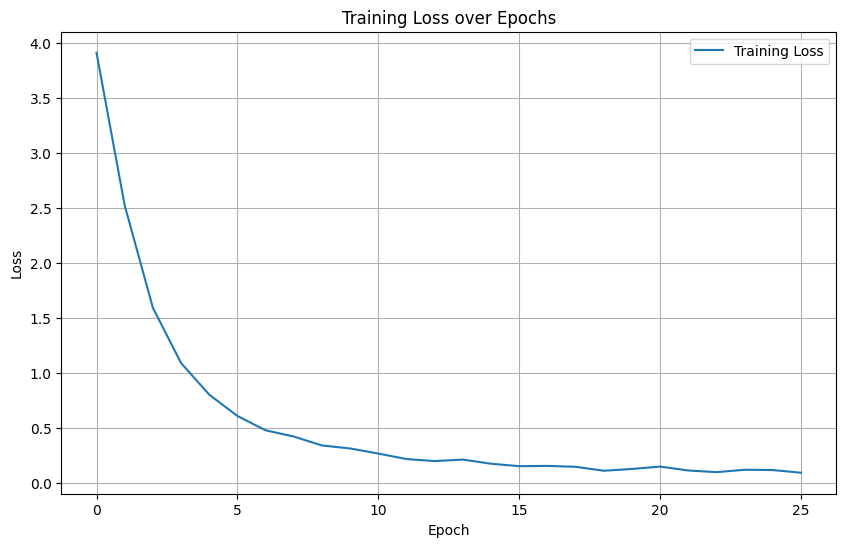

In [7]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = outputs.argmax(dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9331


In [9]:
# Save the model's state dictionary
model_save_path = "models/transformer_model_train_2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to models/transformer_model_train_2.pth


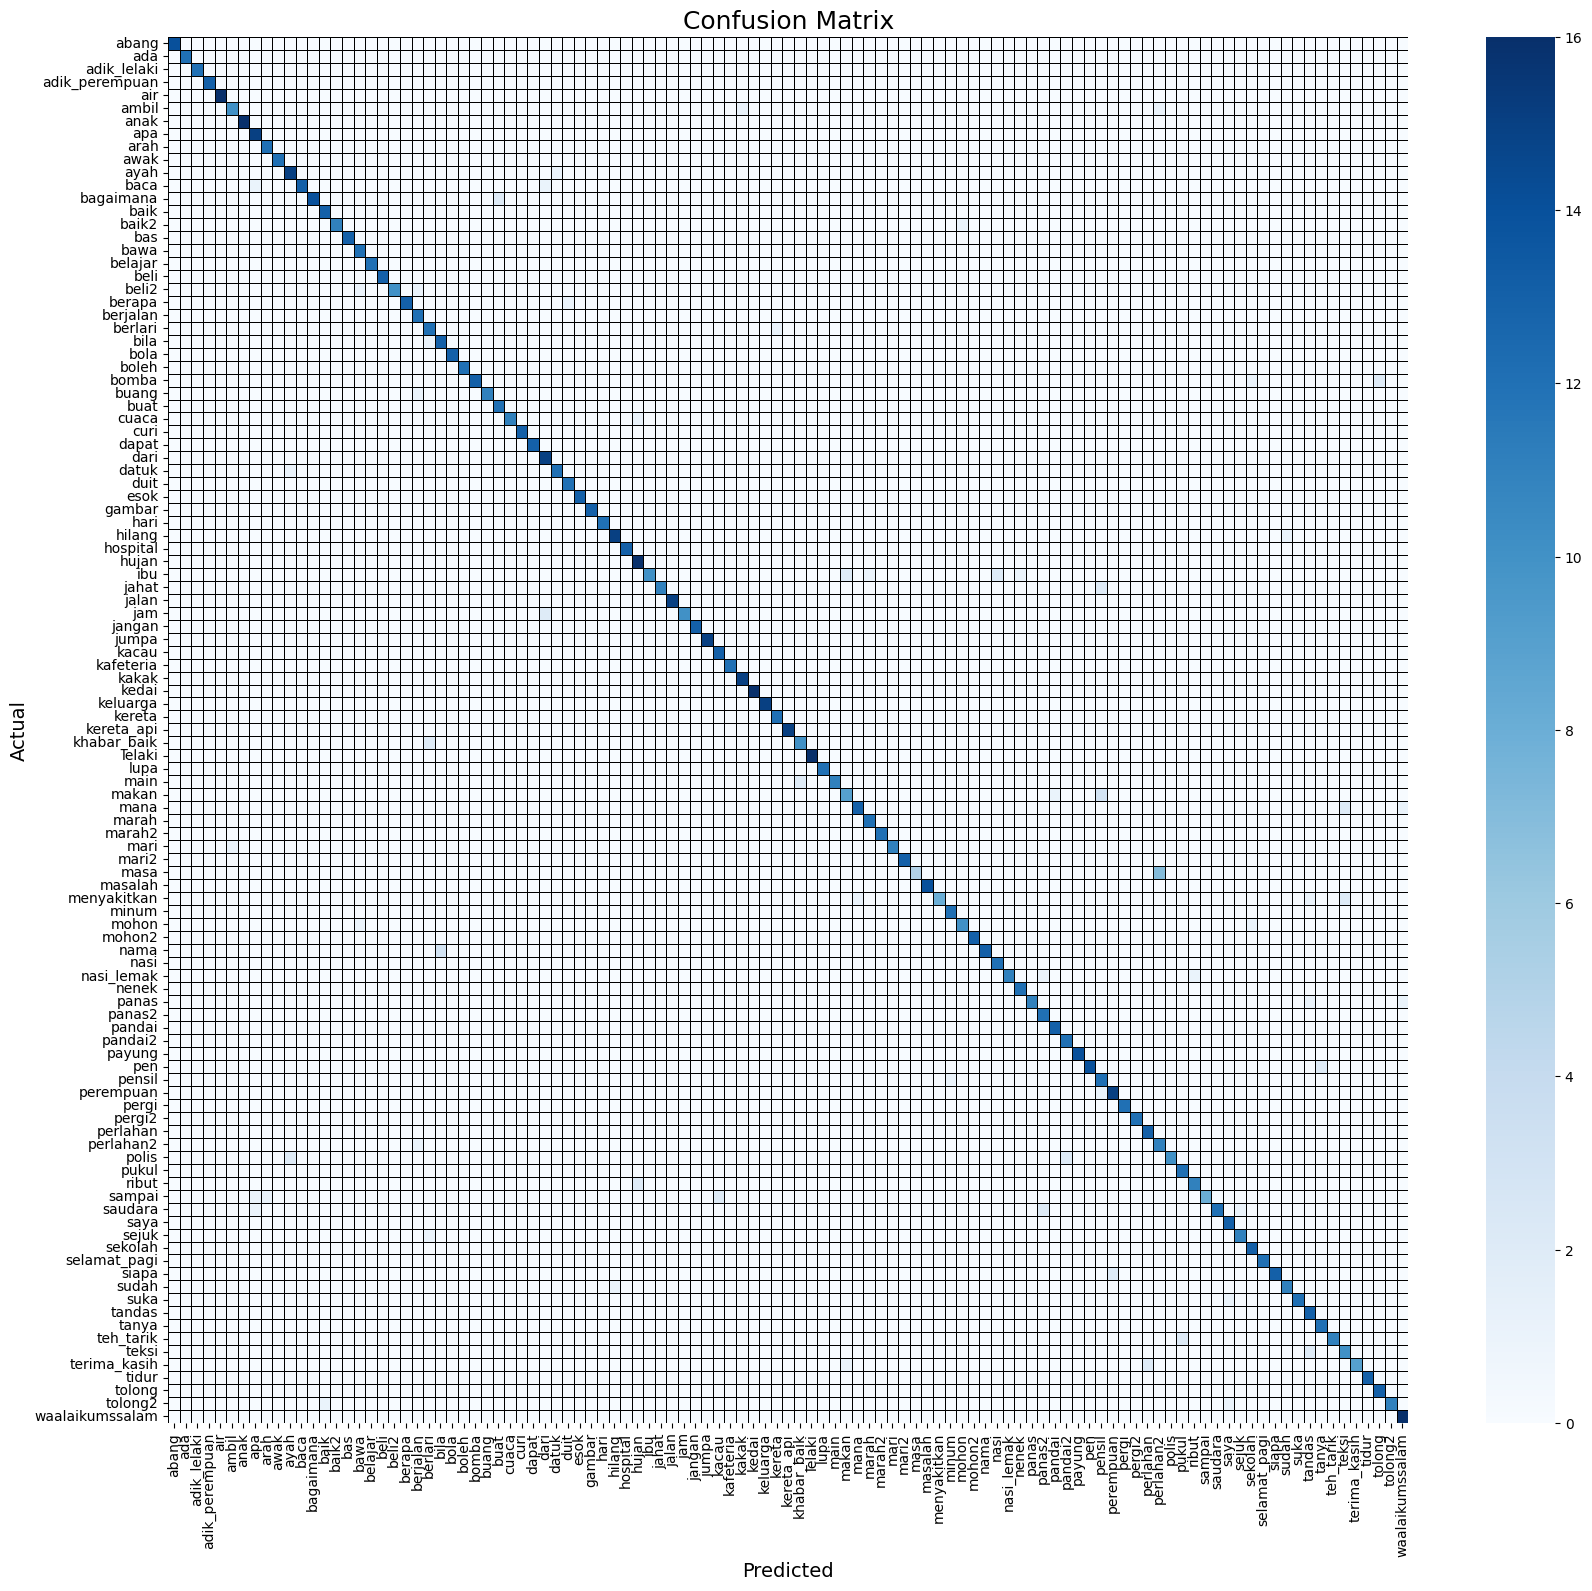

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        16
           5       0.91      0.83      0.87        12
           6       1.00      1.00      1.00        16
           7       0.83      1.00      0.91        15
           8       0.92      1.00      0.96        12
           9       1.00      1.00      1.00        12
          10       0.83      0.94      0.88        16
          11       1.00      0.87      0.93        15
          12       1.00      0.88      0.93        16
          13       0.93      1.00      0.96        13
          14       1.00      0.92      0.96        12
          15       1.00      1.00      1.00        13
          16       0.86      1.00      0.92        12
    

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Generate Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)

# Step 4: Display Confusion Matrix
plt.figure(figsize=(20, 18)) 
sns.heatmap(
    conf_matrix, 
    annot=False, 
    cmap="Blues", 
    xticklabels=list(label_map.keys()), 
    yticklabels=list(label_map.keys()), 
    linecolor='black',  # Grid color
    linewidths=0.5      # Grid line width
)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better fit
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.show()

# Step 5: Print Classification Report
print("Classification Report:")
print(class_report)